# Validation
- Evaluate the models
    - performance metrics
    - AI ethics

In [33]:
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import joblib

import math

# Data

In [34]:
X_train = pd.read_parquet("data/L2/X_train.parquet")
y_train = pd.read_parquet("data/L2/y_train.parquet")
X_val = pd.read_parquet("data/L2/X_val.parquet")
y_val = pd.read_parquet("data/L2/y_val.parquet")
X_score = pd.read_parquet("data/L2/X_score.parquet")

In [35]:
gbm = joblib.load("model/lgb_multiclass.pkl")

# Evaluate
- Metrics

In [36]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import json
import os
import shap
import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary
import joblib

parmas = {"objective": "evaluate", "num_class": 6, "metric": "multi_logloss"}

wandb_run = wandb.init(project="ai-coding-project", config=parmas)

prefix_accuracy,█▁
prefix_f1_macro,█▁
prefix_f1_micro,█▁
prefix_f1_weighted,█▁
prefix_precision_macro,█▁
prefix_precision_micro,█▁
prefix_precision_weighted,█▁
prefix_recall_macro,█▁
prefix_recall_micro,█▁
prefix_recall_weighted,█▁
prefix_accuracy,0.40698


## Multi-Model Metrics

In [37]:
def calculate_multiclass_metrics(y_actual, y_pred_prob, display=True):
    # Convert probabilities to predicted class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_actual, y_pred)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(y_actual, y_pred, average=None)
    recall = recall_score(y_actual, y_pred, average=None)
    f1 = f1_score(y_actual, y_pred, average=None)

    # Calculate macro, micro and weighted averages of precision, recall and F1 score
    precision_macro = precision_score(y_actual, y_pred, average="macro")
    recall_macro = recall_score(y_actual, y_pred, average="macro")
    f1_macro = f1_score(y_actual, y_pred, average="macro")

    precision_micro = precision_score(y_actual, y_pred, average="micro")
    recall_micro = recall_score(y_actual, y_pred, average="micro")
    f1_micro = f1_score(y_actual, y_pred, average="micro")

    precision_weighted = precision_score(y_actual, y_pred, average="weighted")
    recall_weighted = recall_score(y_actual, y_pred, average="weighted")
    f1_weighted = f1_score(y_actual, y_pred, average="weighted")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Generate classification report
    class_report = classification_report(y_actual, y_pred, output_dict=True)

    # Print the metrics
    if display:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (per class): {precision}")
        print(f"Recall (per class): {recall}")
        print(f"F1 Score (per class): {f1}")

        print(f"Macro-Average Precision: {precision_macro:.4f}")
        print(f"Macro-Average Recall: {recall_macro:.4f}")
        print(f"Macro-Average F1 Score: {f1_macro:.4f}")

        print(f"Micro-Average Precision: {precision_micro:.4f}")
        print(f"Micro-Average Recall: {recall_micro:.4f}")
        print(f"Micro-Average F1 Score: {f1_micro:.4f}")

        print(f"Weighted-Average Precision: {precision_weighted:.4f}")
        print(f"Weighted-Average Recall: {recall_weighted:.4f}")
        print(f"Weighted-Average F1 Score: {f1_weighted:.4f}")

        print("Confusion Matrix:")
        print(conf_matrix)

        print("Classification Report:")
        print(classification_report(y_actual, y_pred))

    metrics = {
        f"accuracy": accuracy,
        f"precision": precision,
        f"recall": recall,
        f"f1": f1,
        f"precision_macro": precision_macro,
        f"recall_macro": recall_macro,
        f"f1_macro": f1_macro,
        f"precision_micro": precision_micro,
        f"recall_micro": recall_micro,
        f"f1_micro": f1_micro,
        f"precision_weighted": precision_weighted,
        f"recall_weighted": recall_weighted,
        f"f1_weighted": f1_weighted,
        f"confusion_matrix": conf_matrix,
        f"classification_report": class_report,
    }

    return metrics

In [38]:
def log_wandb_metrics(metrics, wandb_run, prefix="", directory=""):
    # Log metrics to Weights and Biases
    if wandb_run is None:
        wandb_run = wandb.init(project="multiclass-metrics", reinit=True)

    # Log the metrics
    prefixed_metrics = {"prefix_" + k: v for k, v in metrics.items()}
    wandb.log(prefixed_metrics)

    # Save confusion matrix and classification report as JSON files
    with open(f"{directory}/{prefix}_confusion_matrix.json", "w") as f:
        json.dump(metrics["confusion_matrix"].tolist(), f)

    with open(f"{directory}/{prefix}_classification_report.json", "w") as f:
        json.dump(metrics["classification_report"], f)

    # Create wandb artifacts
    artifact = wandb.Artifact("multiclass-metrics-artifacts", type="metrics")
    artifact.add_file(f"{directory}/{prefix}_confusion_matrix.json")
    artifact.add_file(f"{directory}/{prefix}_classification_report.json")

    # Log the artifacts
    wandb_run.log_artifact(artifact)

In [39]:
def log_wandb_shap(model, data, wandb_run, directory=""):
    # Log metrics to Weights and Biases
    if wandb_run is None:
        wandb_run = wandb.init(project="multiclass-metrics", reinit=True)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    # Save SHAP values
    shap_values_filename = f"{directory}/shap_values.npy"
    np.save(shap_values_filename, shap_values.values)

    shap_artifact = wandb.Artifact("shap-artifact", type="shap")
    shap_artifact.add_file(shap_values_filename)
    wandb_run.log_artifact(shap_artifact)

    # Save SHAP summary plot
    shap.summary_plot(shap_values, data, feature_names=data.columns, show=False)
    shap_summary_filename = f"{directory}/shap_summary.png"
    plt.savefig(shap_summary_filename)
    # plt.close()

    wandb_run.log({"SHAP Summary Plot": wandb.Image(shap_summary_filename)})

## Train Metrics

In [40]:
policy_cat_map = {
    "Medical": 0,
    "Critical Illness": 1,
    "Endowment": 2,
    "Investment": 3,
    "Whole Life": 4,
    "Term Life": 5,
}

Accuracy: 0.9488
Precision (per class): [0.91052632 0.97457627 1.         0.92307692 1.         0.95238095]
Recall (per class): [0.97740113 0.92       0.8974359  0.96       1.         1.        ]
F1 Score (per class): [0.94277929 0.94650206 0.94594595 0.94117647 1.         0.97560976]
Macro-Average Precision: 0.9601
Macro-Average Recall: 0.9591
Macro-Average F1 Score: 0.9587
Micro-Average Precision: 0.9488
Micro-Average Recall: 0.9488
Micro-Average F1 Score: 0.9488
Weighted-Average Precision: 0.9512
Weighted-Average Recall: 0.9488
Weighted-Average F1 Score: 0.9488
Confusion Matrix:
[[173   3   0   1   0   0]
 [  9 115   0   0   0   1]
 [  7   0  70   1   0   0]
 [  1   0   0  24   0   0]
 [  0   0   0   0  24   0]
 [  0   0   0   0   0  20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       177
           1       0.97      0.92      0.95       125
           2       1.00      0.90      0.95        78
        

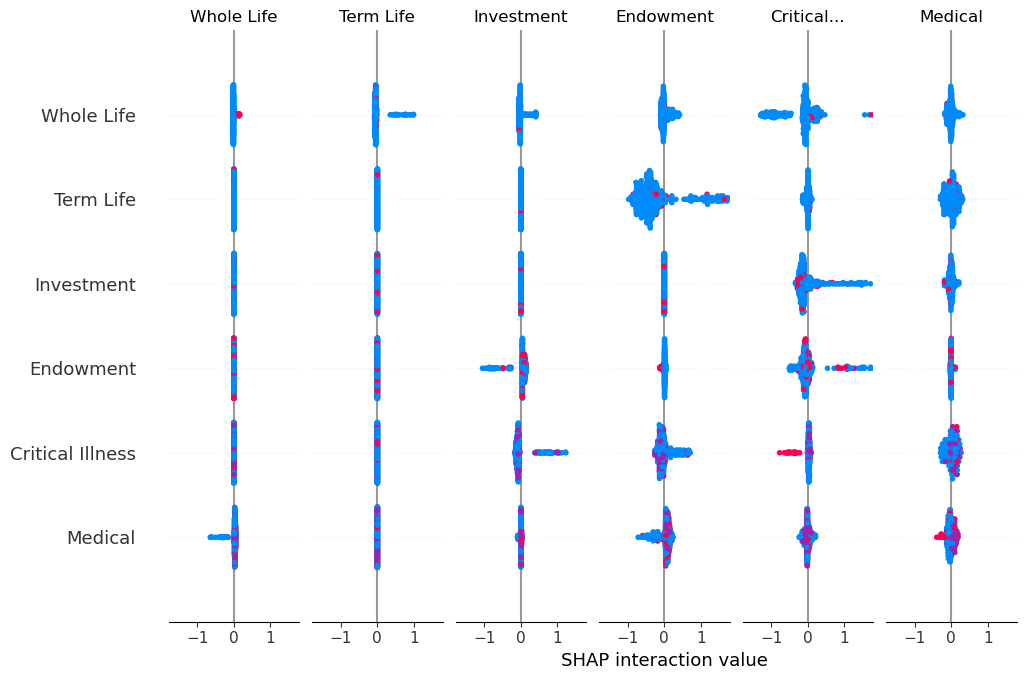

In [41]:
# predict
y_train_predict_prob = gbm.predict(X_train, num_iteration=gbm.best_iteration)
train_metrics = calculate_multiclass_metrics(y_train, y_train_predict_prob)
log_wandb_metrics(train_metrics, wandb_run, prefix="train", directory="tmpt")
log_wandb_shap(gbm, X_train, wandb_run, directory="tmpt")

## Validation Metrics 

In [42]:
y_val_predict_prob = gbm.predict(X_val, num_iteration=gbm.best_iteration)
val_metrics = calculate_multiclass_metrics(y_val, y_val_predict_prob, wandb_run)
log_wandb_metrics(val_metrics, wandb_run, prefix="val", directory="tmpt")

Accuracy: 0.4070
Precision (per class): [0.49056604 0.34       0.11111111 0.         0.         0.        ]
Recall (per class): [0.65       0.34693878 0.05       0.         0.         0.        ]
F1 Score (per class): [0.55913978 0.34343434 0.06896552 0.         0.         0.        ]
Macro-Average Precision: 0.1569
Macro-Average Recall: 0.1745
Macro-Average F1 Score: 0.1619
Micro-Average Precision: 0.4070
Micro-Average Recall: 0.4070
Micro-Average F1 Score: 0.4070
Weighted-Average Precision: 0.3380
Weighted-Average Recall: 0.4070
Weighted-Average F1 Score: 0.3659
Confusion Matrix:
[[52 23  3  0  1  1]
 [26 17  3  3  0  0]
 [14  4  1  0  0  1]
 [ 7  2  1  0  0  1]
 [ 1  4  0  0  0  0]
 [ 6  0  1  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.65      0.56        80
           1       0.34      0.35      0.34        49
           2       0.11      0.05      0.07        20
           3       0.00      0.00      0.00 

### Confusion Matrix

<Axes: >

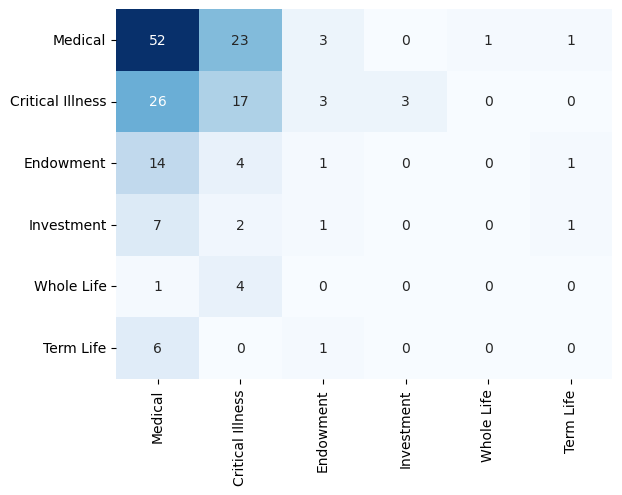

In [43]:
sns.heatmap(
    val_metrics["confusion_matrix"],
    annot=True,
    cmap="Blues",
    cbar=False,
    xticklabels=policy_cat_map.keys(),
    yticklabels=policy_cat_map.keys(),
)

### Classification Report

In [44]:
pd.DataFrame(val_metrics["classification_report"])

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.490566,0.340000,0.111111,0.0,0.0,0.0,0.406977,0.156946,0.337951
recall,0.650000,0.346939,0.050000,0.0,0.0,0.0,0.406977,0.174490,0.406977
f1-score,0.559140,0.343434,0.068966,0.0,0.0,0.0,0.406977,0.161923,0.365923
support,80.000000,49.000000,20.000000,11.0,5.0,7.0,0.406977,172.000000,172.000000


# Ethics
- Via Fairlearn package, assessing and logging fariness through metrics

In [45]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])["Purchase_Policy"]

In [46]:
y_pred_prob = gbm.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)

In [47]:
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    count,
    selection_rate,
    false_negative_rate,
    false_positive_rate,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score
import functools

recall = functools.partial(recall_score, average="micro")
precision = functools.partial(precision_score, average="micro")
accuracy = functools.partial(accuracy_score)

# Initialize Wandb run
wandb_run = wandb.init(project="ai-ethics-evaluation")

prefix_accuracy,█▁
prefix_f1_macro,█▁
prefix_f1_micro,█▁
prefix_f1_weighted,█▁
prefix_precision_macro,█▁
prefix_precision_micro,█▁
prefix_precision_weighted,█▁
prefix_recall_macro,█▁
prefix_recall_micro,█▁
prefix_recall_weighted,█▁
prefix_accuracy,0.40698


### Marriage

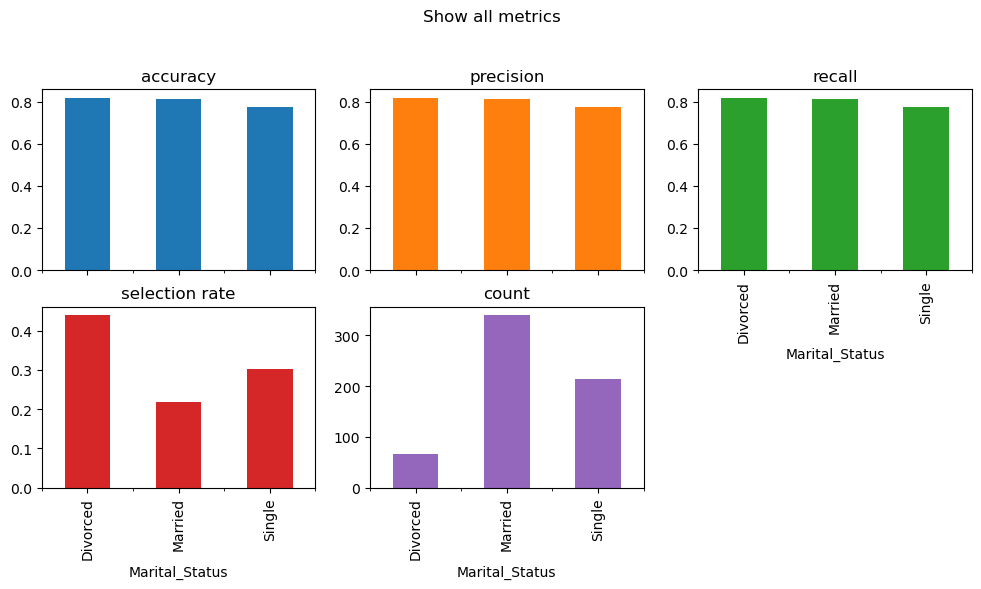

In [49]:
# Evaluate fairness metrics
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=y,
    y_pred=y_pred,
    sensitive_features=X["Marital_Status"],
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
shap_summary_filename = f"tmpt/fairness_marriage.png"
plt.savefig(shap_summary_filename)

wandb_run.log({"Fairness Marriage Plot": wandb.Image(shap_summary_filename)})

In [50]:
### Gender

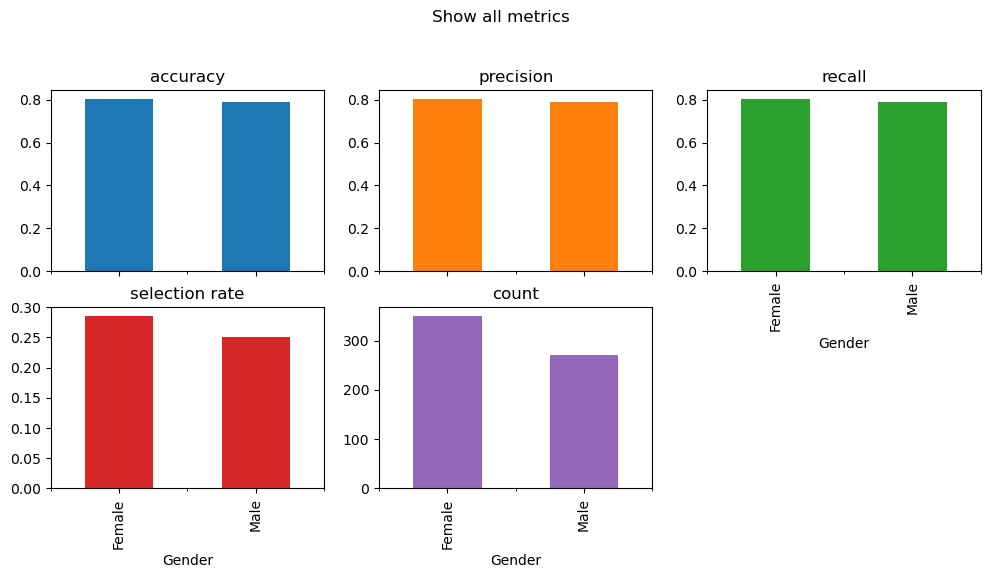

In [51]:
# Evaluate fairness metrics
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "selection rate": selection_rate,
        "count": count,
    },
    y_true=y,
    y_pred=y_pred,
    sensitive_features=X["Gender"],
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
shap_summary_filename = f"tmpt/fairness_gender.png"
plt.savefig(shap_summary_filename)

wandb_run.log({"Fairness Gender Plot": wandb.Image(shap_summary_filename)})